In [1]:
# In your terminal:
# !pip install --upgrade --quiet networkx
# pip install rpy2
# pip install tzlocal

# On R:
# install.packages("BiocManager")
# BiocManager::install("graph")
# BiocManager::install("RBGL")
# BiocManager::install("Rgraphviz")
# install.packages("pcalg")
# install.packages("SMPracticals")

In [2]:
%load_ext rpy2.ipython

# Libraries Required:

In [3]:
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import deque
from sklearn.preprocessing import scale
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import Lasso

plt.rcParams['figure.figsize'] = [20, 10]

In [5]:
%%R
library("pcalg")
library("SMPracticals")

#  Functions to Generate Data and Graphical Displays

In [6]:
def partial_correlation(d, i, j):
    """ Estimate partial correlation between i and j """
    om = np.linalg.inv(np.cov(d.T))
    return - om[i,j] / np.sqrt(om[i,i] * om[j,j])

def partial_correlation_ols(d, i, j, z):
    """ Estimate partial correlation between i and j conditional on z"""
    fit = lambda i: sm.OLS(data[:, [i]], data[:, z]).fit()
    return np.corrcoef(fit(i).resid, fit(j).resid)[0,1]

def plot_dag(dag, layout = nx.kamada_kawai_layout): 
    """ Plots our DAGs with edge weights and labels """
    graph = nx.from_numpy_array(np.abs(dag.adjacency), create_using = nx.DiGraph)
    pos = layout(graph)
    weights = [d['weight'] for i,j,d in graph.edges.data()]
    edges = nx.draw_networkx_edges(graph, pos, edge_cmap = plt.cm.Blues, edge_color = weights)
    labels = nx.draw_networkx_labels(graph, pos)
    nodes = nx.draw_networkx_nodes(graph, pos, with_labels = True)

    pc = matplotlib.collections.PatchCollection(edges, cmap=plt.cm.Blues)
    pc.set_array(weights)
    plt.colorbar(pc)

In [7]:
def emom(tau, N):
    """ Exponential MoM prior @DavidRossel """ #eMoM distribution to generate weight of the tree branches -> easy to learn 
    dat = np.zeros(0)
    while True:
        draw = np.random.normal(0,1,N)
        prob = np.exp( - tau / draw**2)
        idx = prob > np.random.uniform(0, 1, N)
        dat = np.concatenate([dat, draw[idx]])
        if len(dat) >= N:
            return dat[:N]

class DAG(): # Directed acyclic graph
    def __init__(self, tot, avg_children = 3, noise = .5):
        self.noise = noise #Each child  is a linear combination of a parent and noise CHILD = w*PARENT + noise 
        self.lam = avg_children # Mean Poisson distribution 
        self.i = 0
        self.sorted_adjacency = np.zeros((tot,tot))
        self.new_children = deque([0])
        self.tot = tot
        self.nodes = False

    def _shuffle(self, a):
        n = a.shape[0]
        self.idx = np.random.choice(range(n), size = n, replace=False)
        return a[self.idx].T[self.idx].T
    
    def generate_nodes(self):
        """ Implements a breadth-first generation of nodes """
        while self.new_children:
            i = self.new_children.pop()
            left = self.tot - self.i            
            children = np.random.poisson(self.lam, 1)[0]            
            children = children if left - children >= 0 else left
            connections = [self.i + i for i in range(children)]
            
            # Generates random normal 0,1 edges
            self.sorted_adjacency[i, connections] = emom(.9, children)
            self.i += children
            for c in connections:
                self.new_children.appendleft(c)
            

        # Retry if we did not get a full graph
        if self.i != self.tot:
            self.__init__(self.tot)
            self.generate_nodes()
        
        # Shuffle to get random indices
        self.adjacency = self._shuffle(self.sorted_adjacency) # Adjacency matrix containing the weight of the branches
        self.nodes = True

    def _data(self, n):
        self.data = np.zeros((n,self.tot))
        for i,col in enumerate(self.sorted_adjacency.T):
            dat = self.data.dot(col)
            if np.all(dat == 0):
                dat = np.random.normal(0,1,n)
            self.data[:,i] = dat + np.random.normal(0,self.noise,n)
        return self.data
    
    def generate_data(self, n):
        """ Generates data according to the implied adjacency matrix

        Every node is their parent, times the coefficient in the
        adjacency matrix, plus additive gaussian noise (sd = self.noise).
        """
        if not self.nodes:
            self.generate_nodes()
        dat = self._data(n)
        dat = dat.T[self.idx].T
        return scale(dat)

# Vocabulary:

- **Directed Graph**: A graph is a set of nodes connected by edges. A directed graph is a graph where the relations between the nodes follow a certain direction, indicated by arrows on the edges.
- **D-Separation**: Two nodes are d-separated if we cannot find a path connecting both of them. However, if we apply conditioning operations into colliders or their children nodes, they don't longer block a path. 
- **Types of Relations**:
 <img src="./connectiontypes.png" alt="connections" width="100" height="50">
 
 The first two examples are **chains**, the third is a **fork** and the last is a **collider**.
- **Conditional independence** : $Pr[Y|X,Z] = Pr[Y|Z]$. The probability of an event Y is independent of an event X whenever we take into consideration an event Z.

# Graph Representation of Causal Relations:

A natural way to represent causal relations between variables are directed graphs. An example would be:

<img src="./smokeexample1.png" alt="Example 1" width="400" height="200">

This kind of models two qualitative claims are made:

1. If a node Y is a parent of node X, then Y is causing X.
2. If an element Z d-separates/blocks X and Y, then X and Y are independent conditional on Z. 

In the figure, for example, genes are the cause for lung diseases and, equally interestingly, tar is independent of lung disease conditional on smoking. 


# How to Discover the Underlying Connections:

Given the set of claims of the model, uncovering the underlying connections of the graph consists on determining conditional independence relations between the variables. In the example that we will follow below, relations are linear and Gaussian, hence conditional independence is equivalent to zero partial correlations, something that we can obtain easily from linear regression. 

When relations between variables are not linear, we can use the fact that whenever a variable Y and a variable X are just related by their first moment, then $E[Y|Z] = E[Y|X,Z]$ implies conditional independence of X and Y. For more complex cases, other type of algorithms are being developed trying to understand the differences between densities. 

# Example with artificial data:

In this case, as stated before, we've generated data in such a way that relations are linear and distributions are gaussian. As we can see below, the data consist of 10 nodes whose structure can be visualized below:

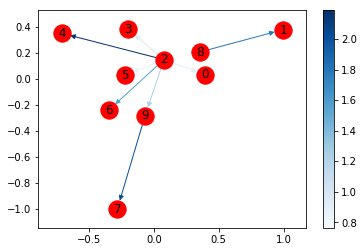

In [8]:
dag = DAG(10, noise=.5) # We generated a directed acyclic graph with 10 vertices and .5 noise
data = dag.generate_data(1000) # How many data points are generated
plot_dag(dag) # The real underlying causal graph

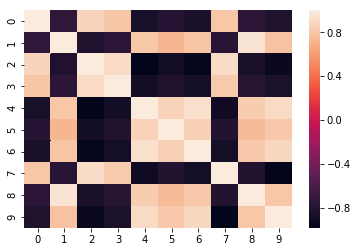

In [9]:
sns.heatmap(np.cov(data.T)) # Correlation Matrix 

A first approach to find partial autocorrelations is just computing the inverse of the correlation matrix:

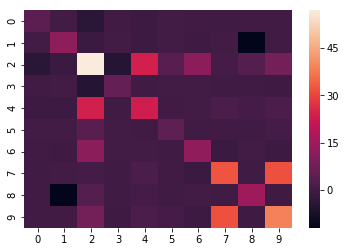

In [10]:
sns.heatmap(np.linalg.inv((np.cov(data.T)))) #Partial correlation matrix:

Other approaches would be to use linear regression (OLS) for each variable:

In [11]:
# Pick a target variable (y) by looking at the above plot.
# Let the rest of the data be potential predictors

def pick(d, i):
    return d[:, i], np.delete(d, i, 1)

y, X = pick(scale(data), 1)

In [12]:
# Take a look at the results from OLS. 
# 1. Are they reasonable? 
# 2. Are there any spurious correlations? 
print(sm.OLS(y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     1288.
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        10:44:41   Log-Likelihood:                -148.37
No. Observations:                1000   AIC:                             314.7
Df Residuals:                     991   BIC:                             358.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0133      0.019     -0.706      0.4

However, given the error term, spurious correlations seem to appear. Hence we will use a methodology which penalizes lack of predictive power which is Lasso. 

In [13]:
def recover_adj(data, precision):
    adj_list = []
    for i in range(10):
        y, X = pick(scale(data), i)
        clf = Lasso(alpha = precision)
        clf.fit(X, y, check_input=True)
        neighbours =[]
        for j, e in enumerate(clf.coef_):
            if e != 0:
                if j > i:
                    neighbours.append(j+1)
                else:
                    neighbours.append(j)
        adj_list.append([i,neighbours])
    return adj_list

In [14]:
recover_adj(data, 0.1) # Pass the function the data and a precision for Lasso and it returns the adjacency matrix

[[0, [2]],
 [1, [8]],
 [2, [0, 2, 4, 5, 6, 9]],
 [3, [2, 5, 6]],
 [4, [2]],
 [5, [2, 3]],
 [6, [2]],
 [7, [9]],
 [8, [1, 2]],
 [9, [2, 7]]]

However we want to visualize the results hence we will apply the following functions:

In [15]:
def fill_diag(arr):
    """ Fills out an array with ones in the diagonal """
    P = arr.shape[0]
    a = np.ones((P,P))
    for i,c in enumerate(arr):
        a[i] = np.insert(c, i, 1)
    return a

def symmetrize(a, union):
    """ Makes adjacency matrix symmetric """
    c = (np.tril(a).T + np.triu(a))
    m = (c + c.T)

    # union or intersection
    if union:
        return m.astype(bool).astype(int)
    else: 
        return (m >= 2).astype(int)

def coefs_to_adjacency(a, union = True):
    """ Converts a 2D numpy array of coefficients into adjacency matrix 

    union: To use the union of the non-zero coefficients of symmetric
    regressions. If False, uses the intersection.
    """
    return symmetrize(fill_diag(a), union)

def score_adjacency(predicted_adj, dag):
    """ Score predicted adjacency matrix
    
    Calculates precision and recall scores of an adjacency matrix
    against the truth of the original DAG instance.    
    """
    preds = predicted_adj.reshape(-1)
    y = np.abs(dag.adjacency).astype(bool).astype(int).reshape(-1)    
    return precision_score(y, preds), recall_score(y, preds)

def regress(data, alpha, fn):
    """ Runs local regressions for each feature in dataset """
    d = [pick(data, i) for i in range(data.shape[1])]
    coefs = [fn(y,X,alpha) for y,X in d]
    return np.array(coefs)

In [16]:
def fn_a(y, X, alpha):
    """Runs Lasso regression to each feature in dataset and returns its neighbours"""
    clf = Lasso(alpha = alpha)
    clf.fit(X, y, check_input=True)
    neighbours =[]
    for j, e in enumerate(clf.coef_):
        if e != 0:
            neighbours.append(1)
        else:
            neighbours.append(0)
    return neighbours

As we can see, using Lasso we obtain a pretty good recall and a not so great precision. 

In [17]:
# Test your regression function and compare

coefs = regress(data, .25, fn_a)
predicted_adj = coefs_to_adjacency(coefs, True)

score_adjacency(predicted_adj, dag)

(0.35714285714285715, 1.0)

/Users/leonardoalcivar/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


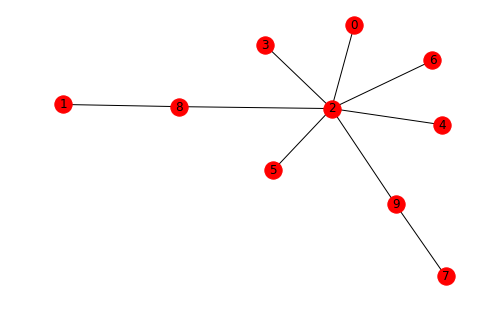

In [18]:
# Visualize your predicted adjacency matrix
G = nx.from_numpy_array(predicted_adj)
nx.draw(G, with_labels=True)

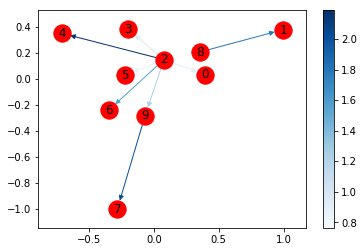

In [19]:
plot_dag(dag)

In the end, we manage to uncover many of the relations between the nodes, however we still need to know the directions of the arrows, this can be done using the PC algorithm.

# Discovering the directions of Causality:

In this part, we will try to discover the causal relationships in real world data, concretely on the mathmarks dataset. The dataset contains the grades for different students in five subjects. 

In [20]:
%%R
data(mathmarks)

In [21]:
%%R
head(mathmarks)

  mechanics vectors algebra analysis statistics
1        77      82      67       67         81
2        63      78      80       70         81
3        75      73      71       66         81
4        55      72      63       70         68
5        63      63      65       70         63
6        53      61      72       64         73


In [22]:
%%R
summary(mathmarks)

   mechanics        vectors         algebra         analysis    
 Min.   : 0.00   Min.   : 9.00   Min.   :15.00   Min.   : 9.00  
 1st Qu.:30.00   1st Qu.:42.00   1st Qu.:45.00   1st Qu.:35.75  
 Median :41.50   Median :51.00   Median :50.00   Median :49.00  
 Mean   :38.95   Mean   :50.59   Mean   :50.60   Mean   :46.68  
 3rd Qu.:49.25   3rd Qu.:60.00   3rd Qu.:57.25   3rd Qu.:57.00  
 Max.   :77.00   Max.   :82.00   Max.   :80.00   Max.   :70.00  
   statistics   
 Min.   : 9.00  
 1st Qu.:31.00  
 Median :40.00  
 Mean   :42.31  
 3rd Qu.:51.50  
 Max.   :81.00  


In [23]:
%%R
suffStat <- list(C=cor(mathmarks), n=nrow(mathmarks))
suffStat

$C
           mechanics   vectors   algebra  analysis statistics
mechanics  1.0000000 0.5534052 0.5467511 0.4093920  0.3890993
vectors    0.5534052 1.0000000 0.6096447 0.4850813  0.4364487
algebra    0.5467511 0.6096447 1.0000000 0.7108059  0.6647357
analysis   0.4093920 0.4850813 0.7108059 1.0000000  0.6071743
statistics 0.3890993 0.4364487 0.6647357 0.6071743  1.0000000

$n
[1] 88



At first sight, it seems that many of the subjects are quite correlated, which makes sense since they belong to the same degree.

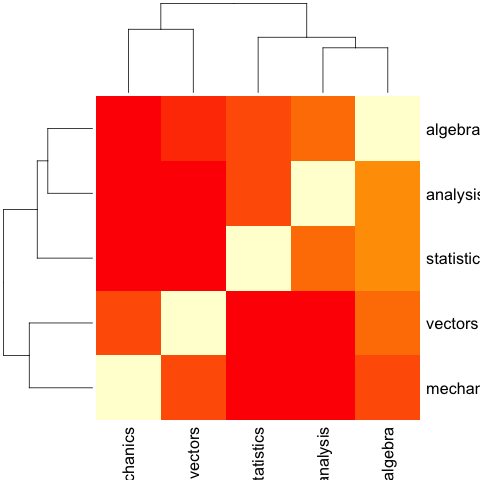

In [24]:
%%R
heatmap(suffStat$C)

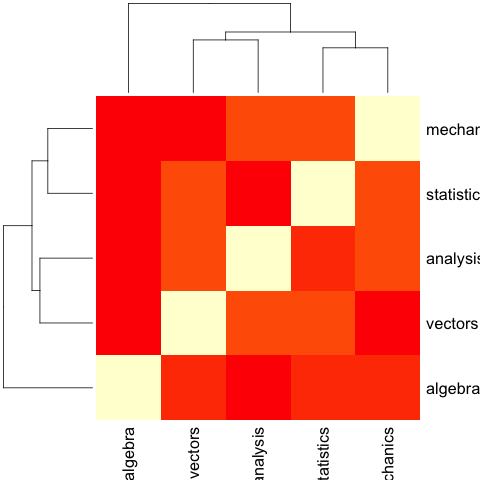

In [25]:
%%R
heatmap(solve(suffStat$C)) #As before, we try to first discover the partial autocorrelations using 
                            #the inverse of the correlation matrix.

The heatmap shows a possible relation between vectors and mechanics and algebra but is not that easy to interpret. Nonetheless, we could derive a graph representation for this data which would look like this:

<img src="./mathmarks.png" alt="Example 1" width="400" height="200">

**Without taking into consideration the arrows.**


Therefore, now, in order to discover the relationship between the variables we can apply the PC algorithm:
The algorithm basically begins with a fully connected graph and remove edges using the conditiona independence relations. In fact, it also finds the directions of the arrows by trying the same rules.

In [26]:
%%R
pc.fit <- pc(suffStat, indepTest=gaussCItest, p=ncol(mathmarks),alpha=0.005)

In [27]:
%%R
pc.fit

Object of class 'pcAlgo', from Call:
pc(suffStat = suffStat, indepTest = gaussCItest, alpha = 0.005, 
    p = ncol(mathmarks))
Number of undirected edges:  1 
Number of directed edges:    3 
Total number of edges:       4 


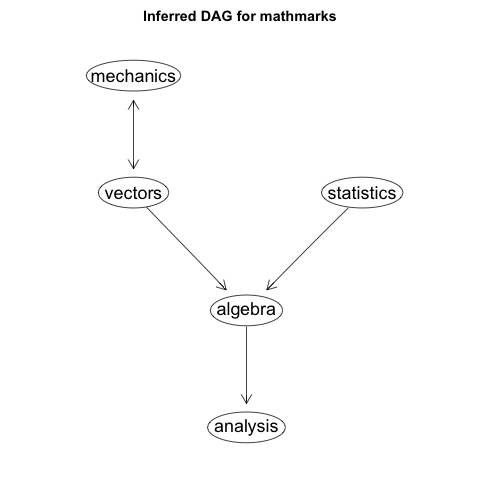

In [29]:
%%R
library(Rgraphviz)
plot(pc.fit,labels=colnames(mathmarks),main="Inferred DAG for mathmarks")

In the end, the following graph is obtained. As we can see, it seems that algebra is the main source for the subject analyis whereas it is a combination between statistics and vectors. Nevertheless, the relation between mechanics and vectors coulnd't be obtained just with the test, hence in this case we should run some experimentation. 